# Traffic Light Object Detection

In [1]:
import os
import cv2
import torch
import zipfile
import dotenv

import numpy as np
import seaborn as sns
import supervision as sv
import torchvision as tv
import matplotlib.pyplot as plt
import torch.nn.functional as F

from dataclasses import dataclass

from ultralytics.models import YOLO
from urllib.request import urlretrieve


dotenv.load_dotenv()

True

In [2]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    IMGSZ: tuple[int, int] = (640, 640)
    ROOT: str = "/teamspace/studios/this_studio"
    DATASET_PATH: str = "/teamspace/lightning_storage/traffic-lights-dataset"


@dataclass(frozen=True)
class TrainingConfig:
    TRAIN_IMG_SIZE: int = 640
    NUM_EPOCHS: int = 150
    BATCH_SIZE: int = 16
    PATIENCE: bool = False
    DEVICE = get_default_device()

In [4]:
if not os.path.exists(DatasetConfig.DATASET_PATH):
    os.makedirs(DatasetConfig.DATASET_PATH, exist_ok=True)

if not os.path.exists(f"{DatasetConfig.DATASET_PATH}/Small-Traffic-Light.v1i.yolov11.zip"):
    urlretrieve(
        os.environ["OBJECT_DETECTION"],
        f"{DatasetConfig.DATASET_PATH}/Small-Traffic-Light.v1i.yolov11.zip",
    )

with zipfile.ZipFile(
    f"{DatasetConfig.DATASET_PATH}/Small-Traffic-Light.v1i.yolov11.zip"
) as file:
    file.extractall(f"{DatasetConfig.DATASET_PATH}")

In [5]:
train_dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DatasetConfig.DATASET_PATH}/train/images",
    annotations_directory_path=f"{DatasetConfig.DATASET_PATH}/train/labels",
    data_yaml_path=f"{DatasetConfig.DATASET_PATH}/data.yaml",
)

test_dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DatasetConfig.DATASET_PATH}/valid/images",
    annotations_directory_path=f"{DatasetConfig.DATASET_PATH}/valid/labels",
    data_yaml_path=f"{DatasetConfig.DATASET_PATH}/data.yaml",
)

len(train_dataset), len(test_dataset)

(855, 367)

In [6]:
def draw_bbox(
    image,
    boxes,
    classes,
    scores=None,
    linewidth=2,
    colors=[(0, 255, 0), (0, 0, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)],
    labels=["green", "off", "red", "wait_on", "yellow"],
) -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    h, w, _ = image.shape

    for idx, box in enumerate(boxes):
        xmin = int(box[0])
        ymin = int(box[1])
        xmax = int(box[2])
        ymax = int(box[3])

        image = cv2.rectangle(
            image,
            (xmin, ymin),
            (xmax, ymax),
            color=colors[int(classes[idx])] if classes is not None else (0, 255, 0),
            thickness=linewidth,
        )

        if classes is not None:
            display_text = labels[int(classes[idx])]

            if scores is not None:
                display_text = (
                    display_text + ": " + str(round(100 * scores[idx], 2)) + "%"
                )

            (text_width, text_height), _ = cv2.getTextSize(
                display_text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2
            )

            cv2.rectangle(
                image,
                (xmin, ymin - int(0.9 * text_height)),
                (xmin + int(0.4 * text_width), ymin),
                colors[int(classes[idx])],
                -1,
            )

            image = cv2.putText(
                image,
                display_text,
                (xmin, ymin - int(0.3 * text_height)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                (0, 0, 0),
                1,
            )

    return image

Text(0, 0.5, 'pixels')

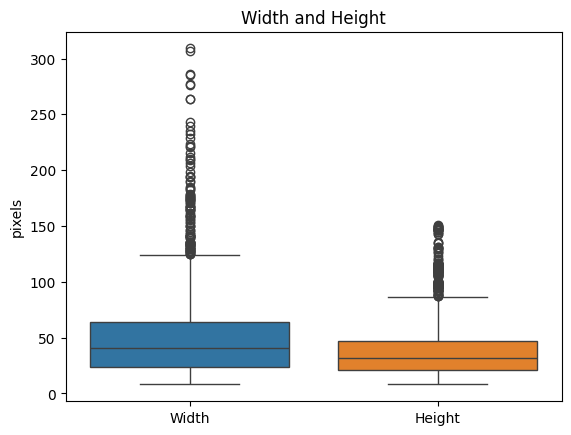

In [7]:
def bboxes_wh_mean_std(dataset):
    widths = []
    heights = []
    for element in dataset:
        sample = element[2]
        xyxy = sample.xyxy
        widths.extend(xyxy[:, 2] - xyxy[:, 0])
        heights.extend(xyxy[:, 3] - xyxy[:, 1])

    return widths, heights


widths, heights = bboxes_wh_mean_std(train_dataset)
fig = sns.boxplot(data={"Width": widths, "Height": heights})
fig.set_title("Width and Height")
fig.set_ylabel("pixels")

In [8]:
def plot_images_at(images, num_images=6):
    ncols = 2
    plt.subplots(num_images // ncols, ncols, figsize=(21, 18))
    plt.suptitle(f"Images at Full pixels of resolution")
    for i in range(num_images):
        k = np.random.randint(0, len(train_dataset) - 1)
        sample = cv2.imread(images[k][0], cv2.IMREAD_COLOR)
        if sample is not None:
            image = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
            image = draw_bbox(image, images[k][2].xyxy, images[k][2].class_id)
            plt.subplot(num_images // ncols, ncols, i + 1)
            plt.imshow(image)
            plt.axis("off")


plot_images_at(train_dataset)

## Train the Model


In [9]:
model = YOLO("yolo11l.pt", task="detect")

In [10]:
model.train(
    data=f"{DatasetConfig.DATASET_PATH}/data.yaml",
    epochs=TrainingConfig.NUM_EPOCHS,
    batch=TrainingConfig.BATCH_SIZE,
    imgsz=TrainingConfig.TRAIN_IMG_SIZE,
    patience=TrainingConfig.PATIENCE,
    device=TrainingConfig.DEVICE,
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/teamspace/lightning_storage/traffic-lights-dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=False, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=No

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7778ea31fe00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

<h2 style = "color: green;">3. Validate the Model </h2>


In [11]:
model = YOLO(
    f"{DatasetConfig.ROOT}/runs/detect/train/weights/best.pt", task="detection"
).to(TrainingConfig.DEVICE)

metrics = model.val(
    data=f"{DatasetConfig.DATASET_PATH}/data.yaml",
)

f"mAP@50:95={metrics.box.map:.03f}"

YOLO11l summary (fused): 190 layers, 25,283,167 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 142.4±61.8 MB/s, size: 248.9 KB)
val: Scanning /teamspace/lightning_storage/traffic-lights-dataset/valid/labels.cache... 367 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 367/367 529.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 4.1it/s 5.6s0.2s
                   all        367        741      0.941      0.709       0.84      0.489
                 green        193        243      0.902      0.831      0.895      0.555
                   off          2          2          1          0        0.5        0.4
                   red        257        373      0.933       0.89      0.938      0.565
               wait_on         97         97      0.911      0.944      0.953      0.481
                yellow         24         26      0.958      0.877      0.916      0.445

'mAP@50:95=0.489'

## Inference over a video


In [12]:
urlretrieve(os.environ.get("VIDEO", ""), filename="inference_traffic_light_video.mp4")

('inference_traffic_light_video.mp4',
 <http.client.HTTPMessage at 0x777a4f7269c0>)

In [13]:
results = model.predict("inference_traffic_light_video.mp4", stream=True)

In [14]:
def create_video(video_result_path, results, frame_size=(1280, 720)):
    fourcc = cv2.VideoWriter.fourcc(*"mp4v")
    video = cv2.VideoWriter(video_result_path, fourcc, 25, frame_size)

    colors = [(0, 255, 0), (0, 0, 0), (0, 0, 255), (255, 0, 0), (255, 255, 0)]

    for result in results:
        xyxy = result.boxes.xyxy.cpu().numpy()
        cls = result.boxes.cls.cpu().numpy()
        conf = result.boxes.conf.cpu().numpy()
        image = draw_bbox(
            result.orig_img,
            xyxy,
            cls,
            conf,
            linewidth=2,
            colors=colors,
        )
        video.write(image)

    video.release()


create_video("bboxes_traffic_light_video.mp4", results)


video 1/1 (frame 1/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 91.8ms
video 1/1 (frame 2/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 17.0ms
video 1/1 (frame 3/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 16.7ms
video 1/1 (frame 4/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 17.9ms
video 1/1 (frame 5/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 19.7ms
video 1/1 (frame 6/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 17.2ms
video 1/1 (frame 7/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 20.3ms
video 1/1 (frame 8/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red, 17.3ms
video 1/1 (frame 9/455) /teamspace/studios/this_studio/inference_traffic_light_video.mp4: 384x640 1 red

In [7]:
# https://www.youtube.com/watch?v=IZ-DNqnv66E

from IPython.display import YouTubeVideo

YouTubeVideo("IZ-DNqnv66E", width=600, height=350)